In [ ]:
!git clone https://github.com/usydnlp/Glocal_K.git


Cloning into 'Glocal_K'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 80 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (80/80), 7.97 MiB | 3.20 MiB/s, done.


In [ ]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [ ]:
from time import time
from scipy.sparse import csc_matrix
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
import networkx as nx
import matplotlib.pyplot as plt

torch.manual_seed(1284)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
sn.set()

In [ ]:
def plot_history(list_train_rmse, list_val_rmse, n_epochs, title):

    plt.figure(figsize=(18,8),linewidth = 7, edgecolor="whitesmoke")
    n = n_epochs

    plt.plot(list(range(1, n_epochs+1)), list_train_rmse, color='red', marker=".")

    plt.plot(list(range(1, n_epochs+1)), list_val_rmse, color='blue')

    plt.legend(['Train RMSE','Validation RMSE'])
    plt.grid(True)

    plt.gca().set_ylim(0.5,3.5)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    title = 'RMSE  for Train & Validation dataset in ' + title
    plt.suptitle(title, size=16, y=0.927)
    plt.show()


In [ ]:

def load_data_100k(split_type, path='./', delimiter='\t'):

    train = np.loadtxt(path+ split_type + '.base', skiprows=0, delimiter=delimiter).astype('int32')
    test = np.loadtxt(path+ split_type + '.test' , skiprows=0, delimiter=delimiter).astype('int32')
    total = np.concatenate((train, test), axis=0)

    n_u = np.unique(total[:,0]).size  # num of users
    n_m = np.unique(total[:,1]).size  # num of movies
    n_train = train.shape[0]  # num of training ratings
    n_test = test.shape[0]  # num of test ratings

    train_r = np.zeros((n_m, n_u), dtype='float32')
    test_r = np.zeros((n_m, n_u), dtype='float32')

    for i in range(n_train):
        train_r[train[i,1]-1, train[i,0]-1] = train[i,2]

    for i in range(n_test):
        test_r[test[i,1]-1, test[i,0]-1] = test[i,2]

    train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries
    test_m = np.greater(test_r, 1e-12).astype('float32')

    print('data matrix loaded')
    print('num of users: {}'.format(n_u))
    print('num of movies: {}'.format(n_m))
    print('num of training ratings: {}'.format(n_train))
    print('num of test ratings: {}'.format(n_test))

    return n_m, n_u, train_r, train_m, test_r, test_m

In [ ]:
data_path = '/content/ml-100k/'

In [ ]:
# Data Load
try:
    path = data_path
    n_m, n_u, train_r, train_m, test_r, test_m = load_data_100k(path=path, delimiter='\t',split_type = 'u1')
except Exception:
    print('Error: Unable to load data')

data matrix loaded
num of users: 943
num of movies: 1682
num of training ratings: 80000
num of test ratings: 20000


In [ ]:
# Common hyperparameter settings
n_hid = 500 # size of hidden layers
n_dim = 5 # inner AE embedding size
n_layers = 2 # number of hidden layers
gk_size = 3 # width=height of kernel for convolution

# Hyperparameters to tune for specific case
max_epoch_p = 500 # max number of epochs for pretraining
max_epoch_f = 1000 # max number of epochs for finetuning
patience_p = 5 # number of consecutive rounds of early stopping condition before actual stop for pretraining
patience_f = 10 # and finetuning
tol_p = 1e-4 # minimum threshold for the difference between consecutive values of train rmse, used for early stopping, for pretraining
tol_f = 1e-5 # and finetuning
lambda_2 = 20. # regularisation of number or parameters
lambda_s = 0.006 # regularisation of sparsity of the final matrix
dot_scale = 1 # dot product weight for global kernel

In [ ]:
def local_kernel(u, v):
    dist = torch.norm(u - v, p=2, dim=2)
    hat = torch.clamp(1. - dist**2, min=0.)
    return hat


class KernelLayer(nn.Module):
    def __init__(self, n_in, n_hid, n_dim, lambda_s, lambda_2, activation=nn.Sigmoid()):
      super().__init__()
      self.W = nn.Parameter(torch.randn(n_in, n_hid))
      self.u = nn.Parameter(torch.randn(n_in, 1, n_dim))
      self.v = nn.Parameter(torch.randn(1, n_hid, n_dim))
      self.b = nn.Parameter(torch.randn(n_hid))

      self.lambda_s = lambda_s
      self.lambda_2 = lambda_2

      nn.init.xavier_uniform_(self.W, gain=torch.nn.init.calculate_gain("relu"))
      nn.init.xavier_uniform_(self.u, gain=torch.nn.init.calculate_gain("relu"))
      nn.init.xavier_uniform_(self.v, gain=torch.nn.init.calculate_gain("relu"))
      nn.init.zeros_(self.b)
      self.activation = activation

    def forward(self, x):
      w_hat = local_kernel(self.u, self.v)

      sparse_reg = torch.nn.functional.mse_loss(w_hat, torch.zeros_like(w_hat))
      sparse_reg_term = self.lambda_s * sparse_reg

      l2_reg = torch.nn.functional.mse_loss(self.W, torch.zeros_like(self.W))
      l2_reg_term = self.lambda_2 * l2_reg

      W_eff = self.W * w_hat  # Local kernelised weight matrix
      y = torch.matmul(x, W_eff) + self.b
      y = self.activation(y)

      return y, sparse_reg_term + l2_reg_term

class KernelNet(nn.Module):
  def __init__(self, n_u, n_hid, n_dim, n_layers, lambda_s, lambda_2):
    super().__init__()
    layers = []
    for i in range(n_layers):
      if i == 0:
        layers.append(KernelLayer(n_u, n_hid, n_dim, lambda_s, lambda_2))
      else:
        layers.append(KernelLayer(n_hid, n_hid, n_dim, lambda_s, lambda_2))
    layers.append(KernelLayer(n_hid, n_u, n_dim, lambda_s, lambda_2, activation=nn.Identity()))
    self.layers = nn.ModuleList(layers)
    self.dropout = nn.Dropout(0.33)

  def forward(self, x):
    total_reg = None
    for i, layer in enumerate(self.layers):
      x, reg = layer(x)
      if i < len(self.layers)-1:
        x = self.dropout(x)
      if total_reg is None:
        total_reg = reg
      else:
        total_reg += reg
    return x, total_reg

In [ ]:
class CompleteNet(nn.Module):
    def __init__(self, kernel_net, n_u, n_m, n_hid, n_dim, n_layers, lambda_s, lambda_2, gk_size, dot_scale):
      super().__init__()
      self.gk_size = gk_size
      self.dot_scale = dot_scale
      self.local_kernel_net = kernel_net
      self.conv_kernel = torch.nn.Parameter(torch.randn(n_m, gk_size**2) * 0.1)
      nn.init.xavier_uniform_(self.conv_kernel, gain=torch.nn.init.calculate_gain("relu"))


    def forward(self, x, x_local):
      gk = self.global_kernel(x_local, self.gk_size, self.dot_scale)
      x = self.global_conv(x, gk)
      x, global_reg_loss = self.local_kernel_net(x)
      return x, global_reg_loss

    def global_kernel(self, input, gk_size, dot_scale):
      avg_pooling = torch.mean(input, dim=1)  # Item (axis=1) based average pooling
      avg_pooling = avg_pooling.view(1, -1)

      gk = torch.matmul(avg_pooling, self.conv_kernel) * dot_scale  # Scaled dot product
      gk = gk.view(1, 1, gk_size, gk_size)

      return gk

    def global_conv(self, input, W):
      input = input.unsqueeze(0).unsqueeze(0)
      conv2d = nn.LeakyReLU()(F.conv2d(input, W, stride=1, padding=1))
      return conv2d.squeeze(0).squeeze(0)

class Loss(nn.Module):
    def forward(self, pred_p, reg_loss, train_m, train_r):
      # L2 loss
      diff = train_m * (train_r - pred_p)
      sqE = torch.nn.functional.mse_loss(diff, torch.zeros_like(diff))
      loss_p = sqE + reg_loss
      return loss_p

In [ ]:
model = KernelNet(n_u, n_hid, n_dim, n_layers, lambda_s, lambda_2).double().to(device)


In [ ]:
complete_model = CompleteNet(model, n_u, n_m, n_hid, n_dim, n_layers, lambda_s, lambda_2, gk_size, dot_scale).double().to(device)


In [ ]:
def dcg_k(score_label, k):
    dcg, i = 0., 0
    for s in score_label:
        if i < k:
            dcg += (2**s[1]-1) / np.log2(2+i)
            i += 1
    return dcg

In [ ]:
def ndcg_k(y_hat, y, k):
    score_label = np.stack([y_hat, y], axis=1).tolist()
    score_label = sorted(score_label, key=lambda d:d[0], reverse=True)
    score_label_ = sorted(score_label, key=lambda d:d[1], reverse=True)
    norm, i = 0., 0
    for s in score_label_:
        if i < k:
            norm += (2**s[1]-1) / np.log2(2+i)
            i += 1
    dcg = dcg_k(score_label, k)
    return dcg / norm

In [ ]:
def call_ndcg(y_hat, y):
    ndcg_sum, num = 0, 0
    y_hat, y = y_hat.T, y.T
    n_users = y.shape[0]

    for i in range(n_users):
        y_hat_i = y_hat[i][np.where(y[i])]
        y_i = y[i][np.where(y[i])]

        if y_i.shape[0] < 2:
            continue

        ndcg_sum += ndcg_k(y_hat_i, y_i, y_i.shape[0])  # user-wise calculation
        num += 1

    return ndcg_sum / num

In [ ]:
best_rmse_ep, best_mae_ep, best_ndcg_ep = 0, 0, 0
best_rmse, best_mae, best_ndcg = float("inf"), float("inf"), 0

time_cumulative = 0
tic = time()

# Pre-Training
optimizer = torch.optim.AdamW(complete_model.local_kernel_net.parameters(), lr=0.001)

def closure():
  optimizer.zero_grad()
  x = torch.Tensor(train_r).double().to(device)
  m = torch.Tensor(train_m).double().to(device)
  complete_model.local_kernel_net.train()
  pred, reg = complete_model.local_kernel_net(x)
  loss = Loss().to(device)(pred, reg, m, x)
  loss.backward()
  return loss

last_rmse = np.inf
counter = 0
list_train_rmse, list_validation_rmse= [], []
print('Train and Evaluation started...')

for i in range(max_epoch_p):
  optimizer.step(closure)
  complete_model.local_kernel_net.eval()
  t = time() - tic
  time_cumulative += t

  pre, _ = model(torch.Tensor(train_r).double().to(device))

  pre = pre.float().cpu().detach().numpy()

  error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
  test_rmse = np.sqrt(error)
  list_validation_rmse.append(test_rmse)


  error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
  train_rmse = np.sqrt(error_train)
  list_train_rmse.append(train_rmse)

  if last_rmse-train_rmse < tol_p:
    counter += 1
  else:
    counter = 0

  last_rmse = train_rmse

  if patience_p == counter:
    print('.-^-._' * 12)
    print('PRE-TRAINING')
    print('Epoch:', i+1, 'test rmse:', test_rmse, 'train rmse:', train_rmse)
    print('Time:', t, 'seconds')
    print('Time cumulative:', time_cumulative, 'seconds')
    print('.-^-._' * 12)
    break
  if i % 50 != 0:
    continue
  print('.-^-._' * 12)
  print('PRE-TRAINING')
  print('Epoch:', i, 'test rmse:', test_rmse, 'train rmse:', train_rmse)
  print('Time:', t, 'seconds')
  print('Time cumulative:', time_cumulative, 'seconds')
  print('.-^-._' * 12)




Train and Evaluation started...
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 0 test rmse: 0.9448361 train rmse: 0.90619963
Time: 0.024135351181030273 seconds
Time cumulative: 0.024135351181030273 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 38 test rmse: 0.9358786 train rmse: 0.8942714
Time: 4.001982688903809 seconds
Time cumulative: 79.30749821662903 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


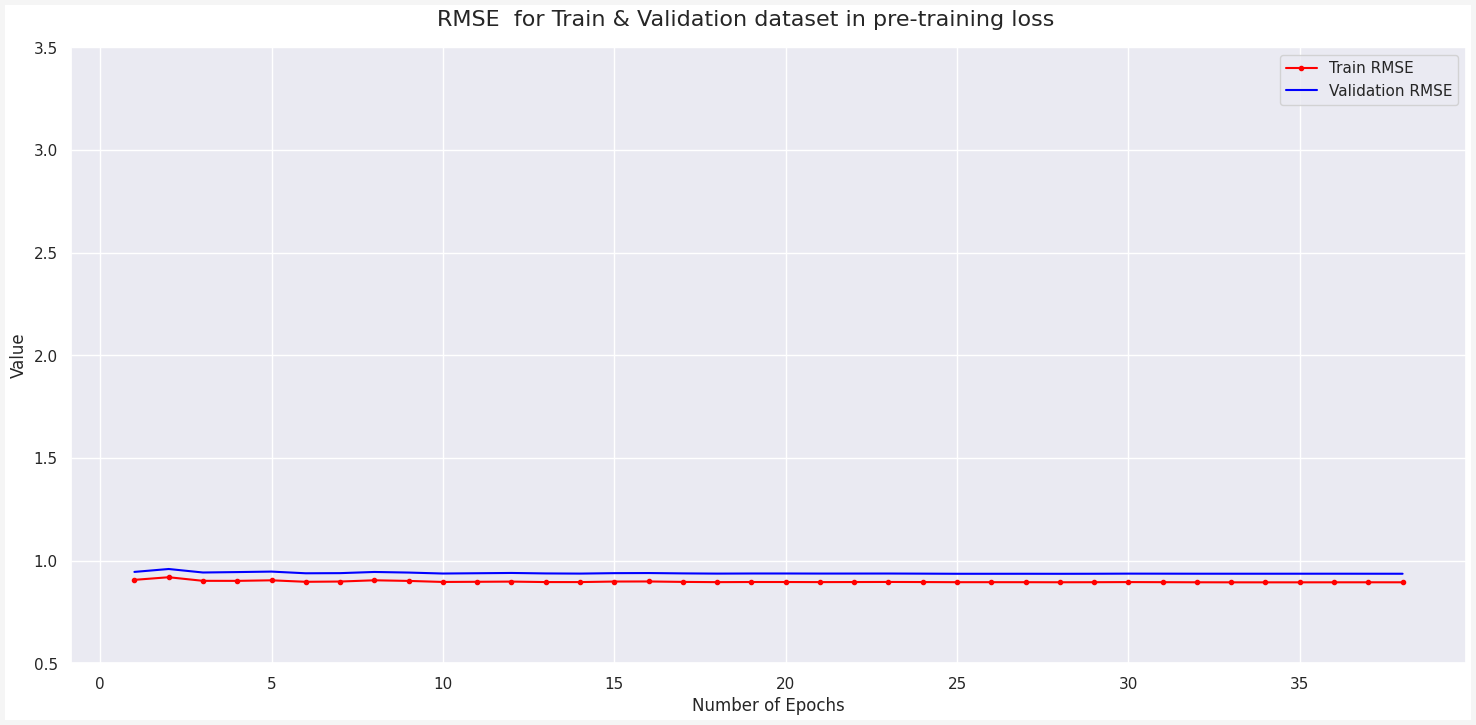

In [ ]:
n_epochs = 38
title = "pre-training loss"
plot_history(list_train_rmse, list_validation_rmse, n_epochs, title)

In [ ]:
# Fine-Tuning

train_r_local = np.clip(pre, 1., 5.)

optimizer = torch.optim.AdamW(complete_model.parameters(), lr=0.001)

def closure():
  optimizer.zero_grad()
  x = torch.Tensor(train_r).double().to(device)
  x_local = torch.Tensor(train_r_local).double().to(device)
  m = torch.Tensor(train_m).double().to(device)
  complete_model.train()
  pred, reg = complete_model(x, x_local)
  loss = Loss().to(device)(pred, reg, m, x)
  loss.backward()
  return loss

last_rmse = np.inf
counter = 0
list_train_rmse, list_validation_rmse= [], []
print('Train and Evaluation started...')
for i in range(max_epoch_f):
  optimizer.step(closure)
  complete_model.eval()
  t = time() - tic
  time_cumulative += t

  pre, _ = complete_model(torch.Tensor(train_r).double().to(device), torch.Tensor(train_r_local).double().to(device))

  pre = pre.float().cpu().detach().numpy()

  error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
  test_rmse = np.sqrt(error)
  list_validation_rmse.append(test_rmse)

  error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
  train_rmse = np.sqrt(error_train)
  list_train_rmse.append(train_rmse)

  test_mae = (test_m * np.abs(np.clip(pre, 1., 5.) - test_r)).sum() / test_m.sum()
  train_mae = (train_m * np.abs(np.clip(pre, 1., 5.) - train_r)).sum() / train_m.sum()

  test_ndcg = call_ndcg(np.clip(pre, 1., 5.), test_r)
  train_ndcg = call_ndcg(np.clip(pre, 1., 5.), train_r)

  if test_rmse < best_rmse:
      best_rmse = test_rmse
      best_rmse_ep = i+1

  if test_mae < best_mae:
      best_mae = test_mae
      best_mae_ep = i+1
  if best_ndcg < test_ndcg:
      best_ndcg = test_ndcg
      best_ndcg_ep = i+1

  if last_rmse-train_rmse < tol_f:
    counter += 1
  else:
    counter = 0

  last_rmse = train_rmse

  if patience_f == counter:
    print('.-^-._' * 12)
    print('FINE-TUNING')
    print('Epoch:', i+1, 'test rmse:', test_rmse, 'test mae:', test_mae, 'test ndcg:', test_ndcg)
    print('Epoch:', i+1, 'train rmse:', train_rmse, 'train mae:', train_mae, 'train ndcg:', train_ndcg)
    print('Time:', t, 'seconds')
    print('.-^-._' * 12)
    break


  if i % 50 != 0:
    continue
  print('.-^-._' * 12)
  print('FINE-TUNING')
  print('Epoch:', i, 'test rmse:', test_rmse, 'test mae:', test_mae, 'test ndcg:', test_ndcg)
  print('Epoch:', i, 'train rmse:', train_rmse, 'train mae:', train_mae, 'train ndcg:', train_ndcg)
  print('Time:', t, 'seconds')
  print('.-^-._' * 12)

Train and Evaluation started...
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 0 test rmse: 1.1085466 test mae: 0.8883283 test ndcg: 0.8305449968746723
Epoch: 0 train rmse: 1.0724488 train mae: 0.8588494 train ndcg: 0.8303938240344333
Time: 109.243891954422 seconds
Time cumulative: 188.55139017105103 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 50 test rmse: 0.92483056 test mae: 0.7293699 test ndcg: 0.8953567419455402
Epoch: 50 train rmse: 0.8779484 train mae: 0.693392 train ndcg: 0.8993964428934407
Time: 141.89931225776672 seconds
Time cumulative: 6490.910495519638 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 100 test rmse: 0.919538 test mae: 0.7245512 test ndcg: 0.8950922147145747
Epoch: 

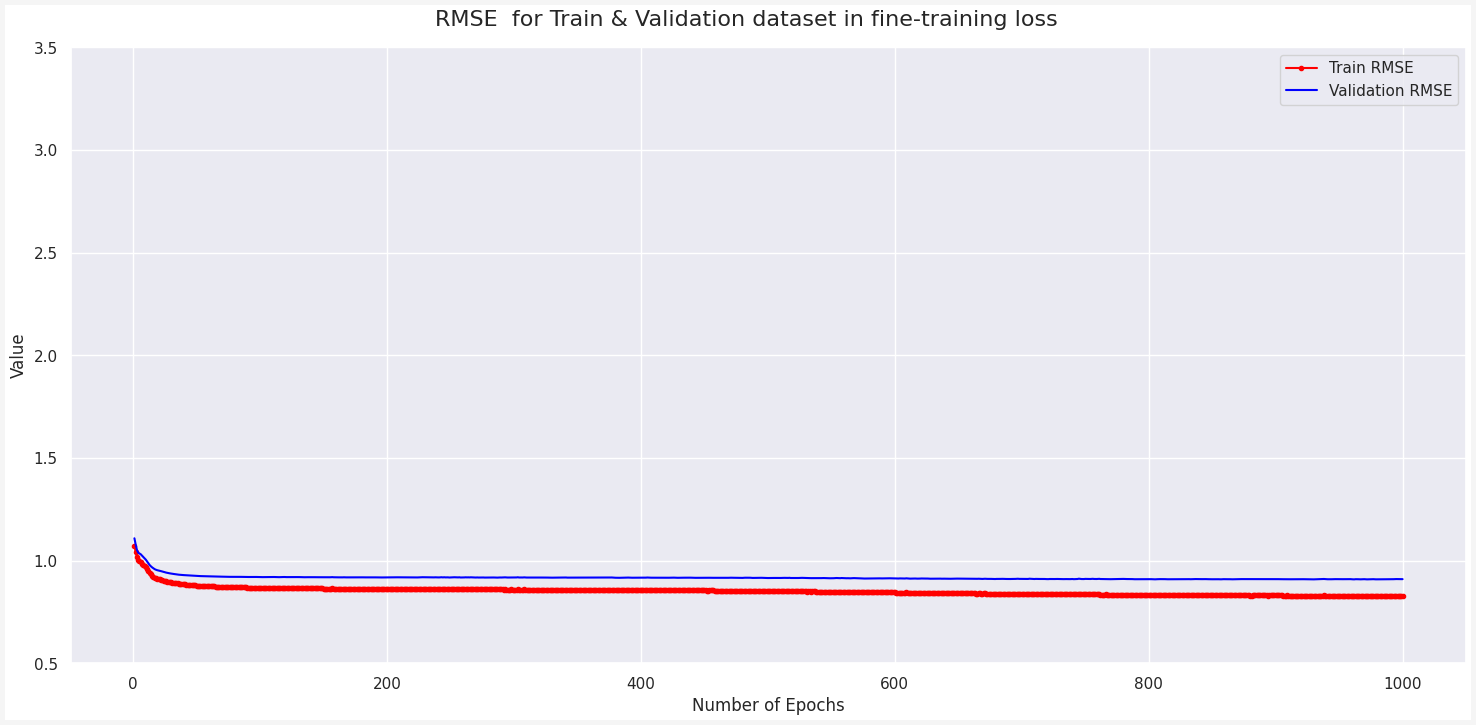

In [ ]:
n_epochs = 1000
title = "fine-training loss"
plot_history(list_train_rmse, list_validation_rmse, n_epochs, title)

In [ ]:
# Final result
print('Epoch:', best_rmse_ep, ' best rmse for u1:', best_rmse)
print('Epoch:', best_mae_ep, ' best mae for u1:', best_mae)
print('Epoch:', best_ndcg_ep, ' best ndcg for u1:', best_ndcg)

Epoch: 972  best rmse for u1: 0.90850276
Epoch: 742  best mae for u1: 0.71465915
Epoch: 875  best ndcg for u1: 0.898332096425803


In [ ]:
# Data Load
try:
    path = data_path
    n_m, n_u, train_r, train_m, test_r, test_m = load_data_100k(path=path, delimiter='\t',split_type = 'u2')
except Exception:
    print('Error: Unable to load data')

data matrix loaded
num of users: 943
num of movies: 1682
num of training ratings: 80000
num of test ratings: 20000


In [ ]:
best_rmse_ep, best_mae_ep, best_ndcg_ep = 0, 0, 0
best_rmse, best_mae, best_ndcg = float("inf"), float("inf"), 0

time_cumulative = 0
tic = time()

# Pre-Training
optimizer = torch.optim.AdamW(complete_model.local_kernel_net.parameters(), lr=0.001)

def closure():
  optimizer.zero_grad()
  x = torch.Tensor(train_r).double().to(device)
  m = torch.Tensor(train_m).double().to(device)
  complete_model.local_kernel_net.train()
  pred, reg = complete_model.local_kernel_net(x)
  loss = Loss().to(device)(pred, reg, m, x)
  loss.backward()
  return loss

last_rmse = np.inf
counter = 0
list_train_rmse, list_validation_rmse= [], []
print('Train and Evaluation started...')

for i in range(max_epoch_p):
  optimizer.step(closure)
  complete_model.local_kernel_net.eval()
  t = time() - tic
  time_cumulative += t

  pre, _ = model(torch.Tensor(train_r).double().to(device))

  pre = pre.float().cpu().detach().numpy()

  error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
  test_rmse = np.sqrt(error)
  list_validation_rmse.append(test_rmse)


  error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
  train_rmse = np.sqrt(error_train)
  list_train_rmse.append(train_rmse)

  if last_rmse-train_rmse < tol_p:
    counter += 1
  else:
    counter = 0

  last_rmse = train_rmse

  if patience_p == counter:
    print('.-^-._' * 12)
    print('PRE-TRAINING')
    print('Epoch:', i+1, 'test rmse:', test_rmse, 'train rmse:', train_rmse)
    print('Time:', t, 'seconds')
    print('Time cumulative:', time_cumulative, 'seconds')
    print('.-^-._' * 12)
    break
  if i % 50 != 0:
    continue
  print('.-^-._' * 12)
  print('PRE-TRAINING')
  print('Epoch:', i, 'test rmse:', test_rmse, 'train rmse:', train_rmse)
  print('Time:', t, 'seconds')
  print('Time cumulative:', time_cumulative, 'seconds')
  print('.-^-._' * 12)



Train and Evaluation started...
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 0 test rmse: 1.3569516 train rmse: 1.3421503
Time: 0.017467260360717773 seconds
Time cumulative: 0.017467260360717773 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 20 test rmse: 1.0205282 train rmse: 1.004419
Time: 2.1518619060516357 seconds
Time cumulative: 23.280384063720703 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


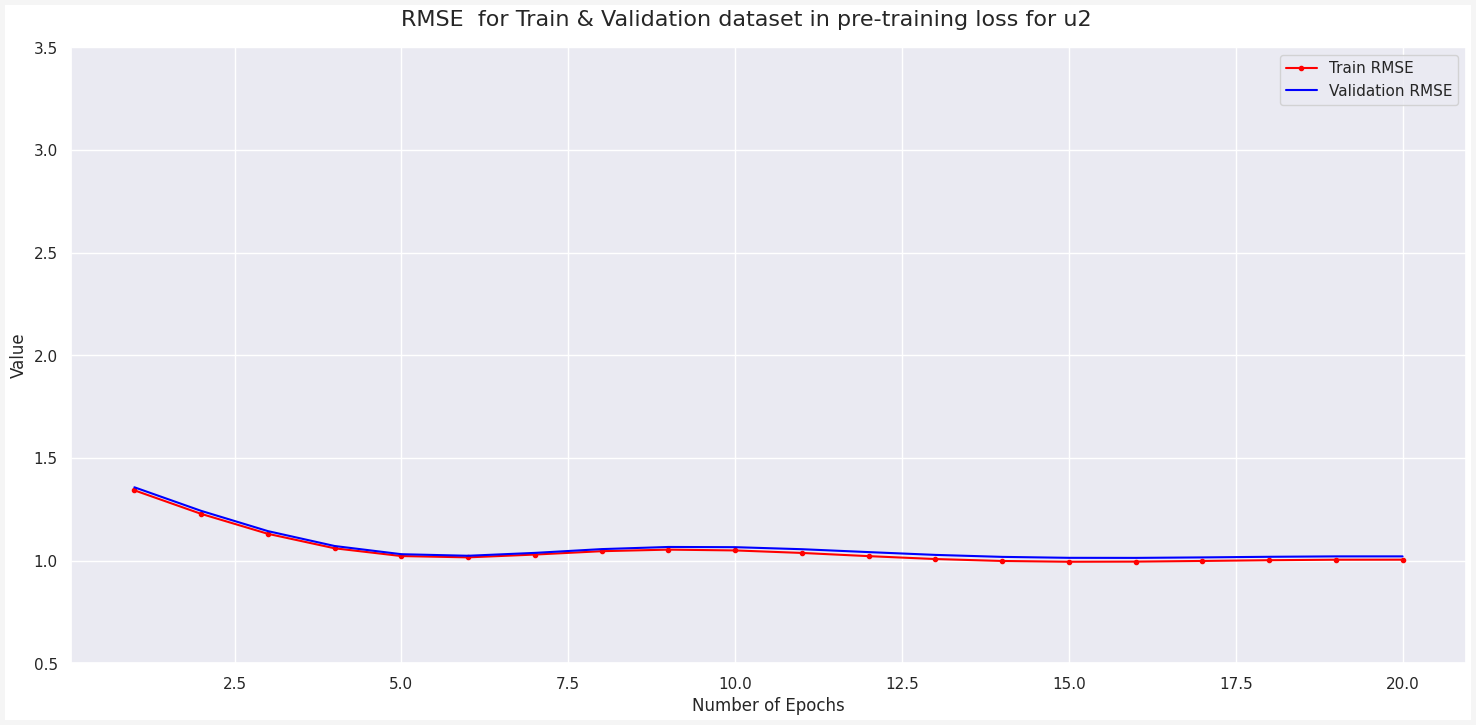

In [ ]:
n_epochs = 20
title = "pre-training loss for u2"
plot_history(list_train_rmse, list_validation_rmse, n_epochs, title)

In [ ]:
# Fine-Tuning

train_r_local = np.clip(pre, 1., 5.)

optimizer = torch.optim.AdamW(complete_model.parameters(), lr=0.001)

def closure():
  optimizer.zero_grad()
  x = torch.Tensor(train_r).double().to(device)
  x_local = torch.Tensor(train_r_local).double().to(device)
  m = torch.Tensor(train_m).double().to(device)
  complete_model.train()
  pred, reg = complete_model(x, x_local)
  loss = Loss().to(device)(pred, reg, m, x)
  loss.backward()
  return loss

last_rmse = np.inf
counter = 0
list_train_rmse, list_validation_rmse= [], []
print('Train and Evaluation started...')
for i in range(max_epoch_f):
  optimizer.step(closure)
  complete_model.eval()
  t = time() - tic
  time_cumulative += t

  pre, _ = complete_model(torch.Tensor(train_r).double().to(device), torch.Tensor(train_r_local).double().to(device))

  pre = pre.float().cpu().detach().numpy()

  error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
  test_rmse = np.sqrt(error)
  list_validation_rmse.append(test_rmse)

  error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
  train_rmse = np.sqrt(error_train)
  list_train_rmse.append(train_rmse)

  test_mae = (test_m * np.abs(np.clip(pre, 1., 5.) - test_r)).sum() / test_m.sum()
  train_mae = (train_m * np.abs(np.clip(pre, 1., 5.) - train_r)).sum() / train_m.sum()

  test_ndcg = call_ndcg(np.clip(pre, 1., 5.), test_r)
  train_ndcg = call_ndcg(np.clip(pre, 1., 5.), train_r)

  if test_rmse < best_rmse:
      best_rmse = test_rmse
      best_rmse_ep = i+1

  if test_mae < best_mae:
      best_mae = test_mae
      best_mae_ep = i+1
  if best_ndcg < test_ndcg:
      best_ndcg = test_ndcg
      best_ndcg_ep = i+1

  if last_rmse-train_rmse < tol_f:
    counter += 1
  else:
    counter = 0

  last_rmse = train_rmse

  if patience_f == counter:
    print('.-^-._' * 12)
    print('FINE-TUNING')
    print('Epoch:', i+1, 'test rmse:', test_rmse, 'test mae:', test_mae, 'test ndcg:', test_ndcg)
    print('Epoch:', i+1, 'train rmse:', train_rmse, 'train mae:', train_mae, 'train ndcg:', train_ndcg)
    print('Time:', t, 'seconds')
    print('.-^-._' * 12)
    break


  if i % 50 != 0:
    continue
  print('.-^-._' * 12)
  print('FINE-TUNING')
  print('Epoch:', i, 'test rmse:', test_rmse, 'test mae:', test_mae, 'test ndcg:', test_ndcg)
  print('Epoch:', i, 'train rmse:', train_rmse, 'train mae:', train_mae, 'train ndcg:', train_ndcg)
  print('Time:', t, 'seconds')
  print('.-^-._' * 12)

Train and Evaluation started...
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 0 test rmse: 1.3273208 test mae: 1.0117317 test ndcg: 0.8749501795445801
Epoch: 0 train rmse: 1.3106234 train mae: 0.9994255 train ndcg: 0.8729643132672001
Time: 45.005833864212036 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 50 test rmse: 0.8850288 test mae: 0.6988193 test ndcg: 0.9038724828154188
Epoch: 50 train rmse: 0.8581749 train mae: 0.6806297 train ndcg: 0.9086339036200857
Time: 76.69318318367004 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 100 test rmse: 0.88449055 test mae: 0.69621986 test ndcg: 0.9024241620450681
Epoch: 100 train rmse: 0.8445901 train mae: 0.6682616 train ndcg: 0.9126569816734154
Time:

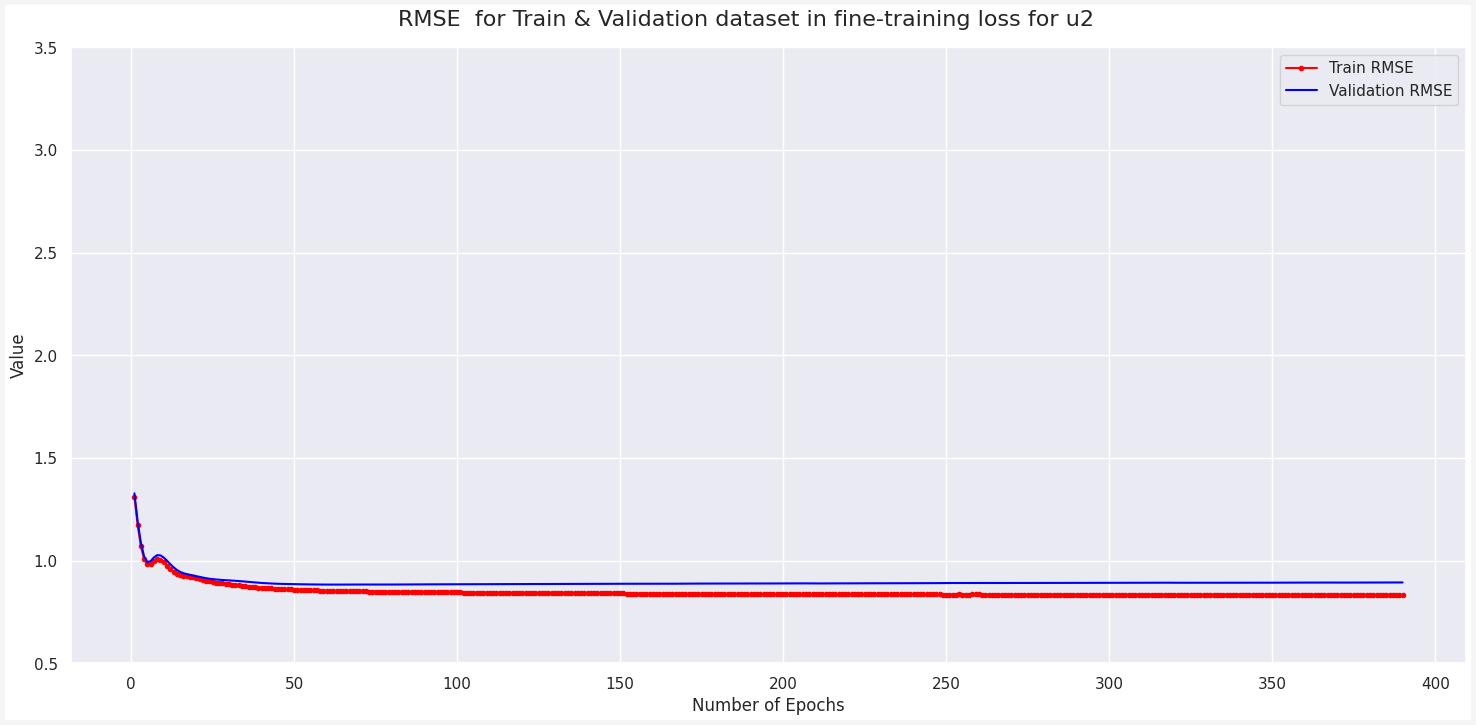

In [ ]:
n_epochs = 390
title = "fine-training loss for u2"
plot_history(list_train_rmse, list_validation_rmse, n_epochs, title)

In [ ]:
# Data Load
try:
    path = data_path
    n_m, n_u, train_r, train_m, test_r, test_m = load_data_100k(path=path, delimiter='\t',split_type = 'u3')
except Exception:
    print('Error: Unable to load data')

data matrix loaded
num of users: 943
num of movies: 1682
num of training ratings: 80000
num of test ratings: 20000


In [ ]:
best_rmse_ep, best_mae_ep, best_ndcg_ep = 0, 0, 0
best_rmse, best_mae, best_ndcg = float("inf"), float("inf"), 0

time_cumulative = 0
tic = time()

# Pre-Training
optimizer = torch.optim.AdamW(complete_model.local_kernel_net.parameters(), lr=0.001)

def closure():
  optimizer.zero_grad()
  x = torch.Tensor(train_r).double().to(device)
  m = torch.Tensor(train_m).double().to(device)
  complete_model.local_kernel_net.train()
  pred, reg = complete_model.local_kernel_net(x)
  loss = Loss().to(device)(pred, reg, m, x)
  loss.backward()
  return loss

last_rmse = np.inf
counter = 0
list_train_rmse, list_validation_rmse= [], []
print('Train and Evaluation started...')

for i in range(max_epoch_p):
  optimizer.step(closure)
  complete_model.local_kernel_net.eval()
  t = time() - tic
  time_cumulative += t

  pre, _ = model(torch.Tensor(train_r).double().to(device))

  pre = pre.float().cpu().detach().numpy()

  error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
  test_rmse = np.sqrt(error)
  list_validation_rmse.append(test_rmse)


  error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
  train_rmse = np.sqrt(error_train)
  list_train_rmse.append(train_rmse)

  if last_rmse-train_rmse < tol_p:
    counter += 1
  else:
    counter = 0

  last_rmse = train_rmse

  if patience_p == counter:
    print('.-^-._' * 12)
    print('PRE-TRAINING')
    print('Epoch:', i+1, 'test rmse:', test_rmse, 'train rmse:', train_rmse)
    print('Time:', t, 'seconds')
    print('Time cumulative:', time_cumulative, 'seconds')
    print('.-^-._' * 12)
    break
  if i % 50 != 0:
    continue
  print('.-^-._' * 12)
  print('PRE-TRAINING')
  print('Epoch:', i, 'test rmse:', test_rmse, 'train rmse:', train_rmse)
  print('Time:', t, 'seconds')
  print('Time cumulative:', time_cumulative, 'seconds')
  print('.-^-._' * 12)

Train and Evaluation started...
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 0 test rmse: 1.3030732 train rmse: 1.3018564
Time: 0.022387266159057617 seconds
Time cumulative: 0.022387266159057617 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 19 test rmse: 1.0189736 train rmse: 1.0059546
Time: 2.132033348083496 seconds
Time cumulative: 21.623827934265137 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._


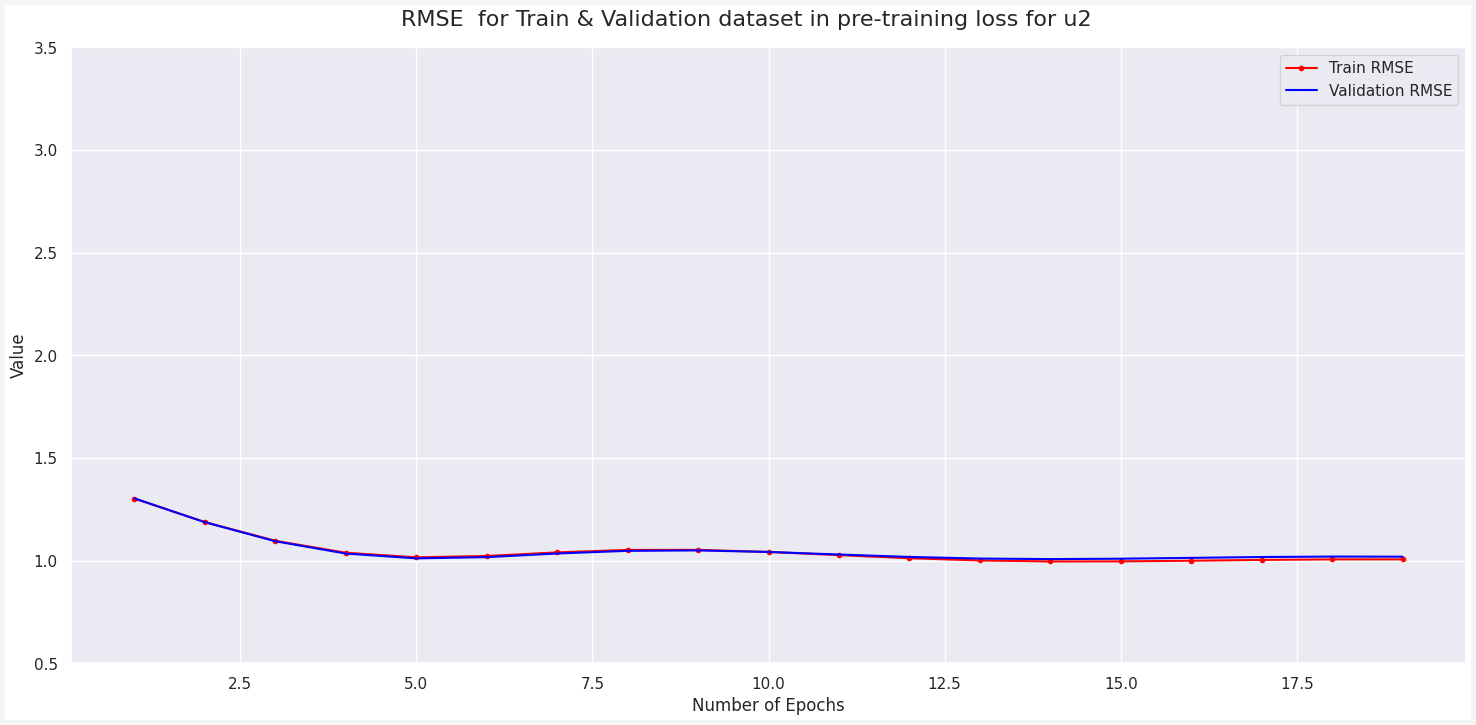

In [ ]:
n_epochs = 19
title = "pre-training loss for u3"
plot_history(list_train_rmse, list_validation_rmse, n_epochs, title)

In [ ]:
# Fine-Tuning

train_r_local = np.clip(pre, 1., 5.)

optimizer = torch.optim.AdamW(complete_model.parameters(), lr=0.001)

def closure():
  optimizer.zero_grad()
  x = torch.Tensor(train_r).double().to(device)
  x_local = torch.Tensor(train_r_local).double().to(device)
  m = torch.Tensor(train_m).double().to(device)
  complete_model.train()
  pred, reg = complete_model(x, x_local)
  loss = Loss().to(device)(pred, reg, m, x)
  loss.backward()
  return loss

last_rmse = np.inf
counter = 0
list_train_rmse, list_validation_rmse= [], []
print('Train and Evaluation started...')
for i in range(max_epoch_f):
  optimizer.step(closure)
  complete_model.eval()
  t = time() - tic
  time_cumulative += t

  pre, _ = complete_model(torch.Tensor(train_r).double().to(device), torch.Tensor(train_r_local).double().to(device))

  pre = pre.float().cpu().detach().numpy()

  error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
  test_rmse = np.sqrt(error)
  list_validation_rmse.append(test_rmse)

  error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
  train_rmse = np.sqrt(error_train)
  list_train_rmse.append(train_rmse)

  test_mae = (test_m * np.abs(np.clip(pre, 1., 5.) - test_r)).sum() / test_m.sum()
  train_mae = (train_m * np.abs(np.clip(pre, 1., 5.) - train_r)).sum() / train_m.sum()

  test_ndcg = call_ndcg(np.clip(pre, 1., 5.), test_r)
  train_ndcg = call_ndcg(np.clip(pre, 1., 5.), train_r)

  if test_rmse < best_rmse:
      best_rmse = test_rmse
      best_rmse_ep = i+1

  if test_mae < best_mae:
      best_mae = test_mae
      best_mae_ep = i+1
  if best_ndcg < test_ndcg:
      best_ndcg = test_ndcg
      best_ndcg_ep = i+1

  if last_rmse-train_rmse < tol_f:
    counter += 1
  else:
    counter = 0

  last_rmse = train_rmse

  if patience_f == counter:
    print('.-^-._' * 12)
    print('FINE-TUNING')
    print('Epoch:', i+1, 'test rmse:', test_rmse, 'test mae:', test_mae, 'test ndcg:', test_ndcg)
    print('Epoch:', i+1, 'train rmse:', train_rmse, 'train mae:', train_mae, 'train ndcg:', train_ndcg)
    print('Time:', t, 'seconds')
    print('.-^-._' * 12)
    break


  if i % 50 != 0:
    continue
  print('.-^-._' * 12)
  print('FINE-TUNING')
  print('Epoch:', i, 'test rmse:', test_rmse, 'test mae:', test_mae, 'test ndcg:', test_ndcg)
  print('Epoch:', i, 'train rmse:', train_rmse, 'train mae:', train_mae, 'train ndcg:', train_ndcg)
  print('Time:', t, 'seconds')
  print('.-^-._' * 12)

Train and Evaluation started...
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 0 test rmse: 1.3385115 test mae: 1.0198686 test ndcg: 0.8789627663199848
Epoch: 0 train rmse: 1.3592145 train mae: 1.0390393 train ndcg: 0.8656649717955145
Time: 18.976744174957275 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 50 test rmse: 0.88576525 test mae: 0.6994317 test ndcg: 0.9090617384686573
Epoch: 50 train rmse: 0.8592123 train mae: 0.6802401 train ndcg: 0.9070791529795235
Time: 56.01943397521973 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
FINE-TUNING
Epoch: 100 test rmse: 0.8850811 test mae: 0.6975175 test ndcg: 0.9085323407679942
Epoch: 100 train rmse: 0.84474033 train mae: 0.66779846 train ndcg: 0.9107401861462457
Time

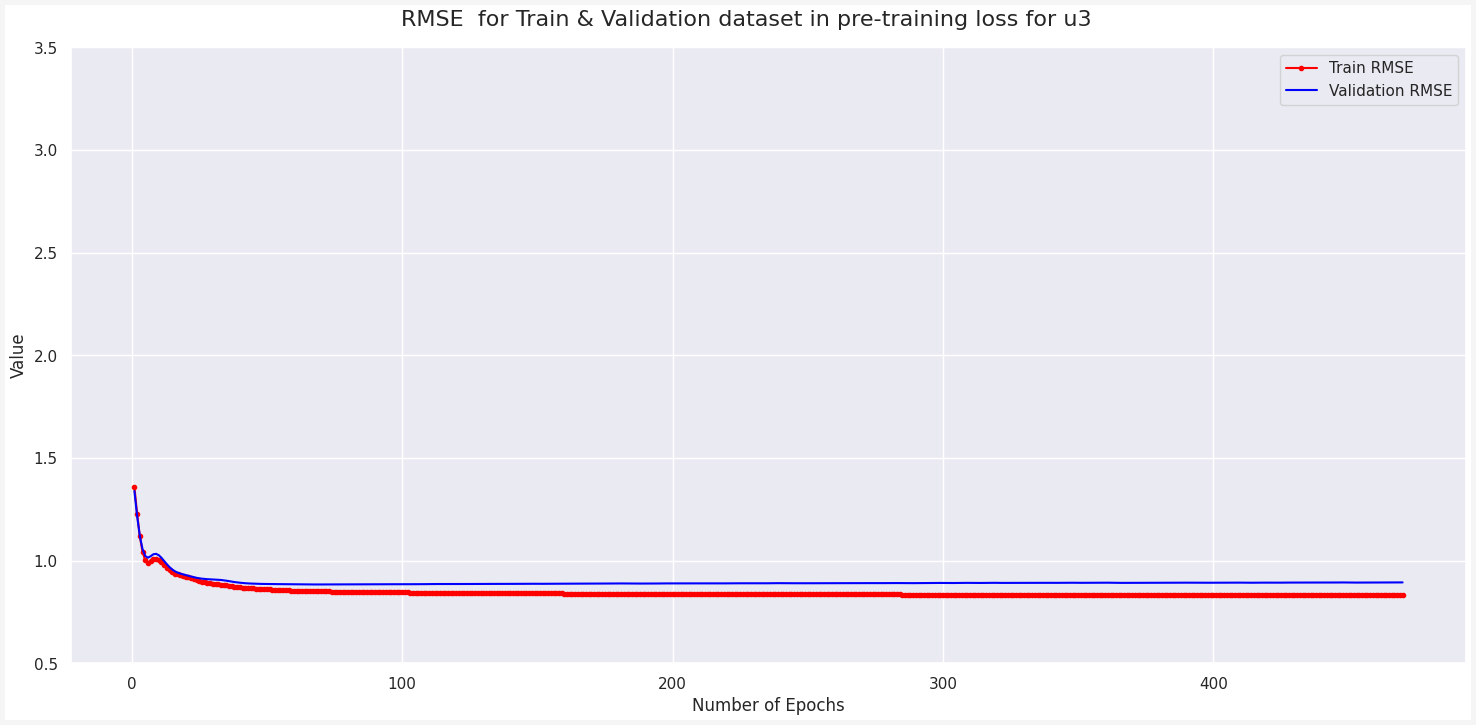

In [ ]:
n_epochs = 470
title = "pre-training loss for u3"
plot_history(list_train_rmse, list_validation_rmse, n_epochs, title)